# Getting in Trump's Head

## Analyse et modélisation des discours de Donald Trump

**Auteurs** : Nicolas Grimaldi, Raphaël Géron

---

### Problématique

Comment caractériser le style oratoire de Donald Trump et peut-on prédire la suite d'une phrase qu'il prononce ?

Ce projet explore les discours publics de Trump à travers:
1. **La collecte de données** via webscraping du site Roll Call
2. **L'analyse descriptive** du corpus (durée, fréquence des mots, évolution temporelle)
3. **La comparaison** avec Biden et Kamala Harris
4. **La modélisation** par N-grammes pour prédire la fin d'une phrase

---

## Partie 1 : Collecte des données (Scraping)

Le site [Roll Call](https://rollcall.com/factbase/) archive les transcriptions des discours politiques américains.

### Architecture du scraping

On utilise **Selenium** pour naviguer sur le site (JavaScript dynamique) et **BeautifulSoup** pour parser le HTML.

Le scraping se fait en 2 étapes :
1. `speech_url_scrap.py` : Récupère la liste des URLs des discours
2. `process_speeches.py` : Pour chaque URL, extrait le titre, la date, les catégories et les transcriptions

In [1]:
import sys, os
import pandas as pd
import numpy as np
import sqlite3
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from datetime import datetime

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

sys.path.insert(0, os.path.abspath('../src'))

### Démonstration du scraping

Voici comment fonctionne notre pipeline. !! ça prend un peu de temps (~5 min) et parfois ça crash !!

In [ ]:
# # Nos fonctions de scraping
# from rollcall.browser_setup import get_browser
# from rollcall.speech_filter_action import open_page_close_popup_and_click_filters
# from rollcall.scroller import scroll_to_bottom
# from rollcall.url_extractor import extract_urls
# from rollcall.storage import store_urls
# from rollcall.speeches_db import init_db

# # Exemple de code pour scraper
# # 1. On ouvre le navigateur
# browser = get_browser()

# # 2. On navigue vers la page et on ferme les popups
# open_page_close_popup_and_click_filters(browser, 'https://rollcall.com/factbase/trump/search/')

# # 3. On scroll jusqu'en bas pour charger tous les résultats
# scroll_to_bottom(browser)

# # 4. On extrait les URLs
# urls = extract_urls(browser)

# # 5. On stocke dans la base de données
# store_urls(urls, db_path="../data/speeches.db")
# print("Le code de scraping est illustré ci-dessus.")
# print("Il n'est pas exécuté ici car les données sont déjà collectées.")

### Scraping d'un discours individuel

Une fois les URLs collectées, on récupère le contenu de chaque discours avec nos fonctions dans `src/rollcall/`.

In [4]:
from rollcall.url_soupper import url_soupper
from rollcall.speech_decomposer import (
    get_title, 
    get_date, 
    get_nbr_sentences_nbr_words_nbr_seconds, 
    get_cleaned_categories, 
    get_candidate_transcriptions
)

# Exemple d'URL d'un discours Trump
url = 'https://rollcall.com/factbase/trump/transcript/donald-trump-speech-hanukkah-reception-white-house-december-16-2025/'

# 1. On récupère le HTML
soup = url_soupper(url)

# 2. On extrait les métadonnées
title = get_title(soup)
date = get_date(soup)
nbr_sentences, nbr_words, nbr_seconds = get_nbr_sentences_nbr_words_nbr_seconds(soup, "Trump")
categories = get_cleaned_categories(soup)

print(f"Titre: {title}")
print(f"Date: {date}")
print(f"Stats: {nbr_sentences} phrases, {nbr_words} mots, {nbr_seconds} secondes")
print(f"Catégories: {categories}")

# 3. On extrait les transcriptions de Trump
trump_transcriptions = get_candidate_transcriptions(soup, "Donald Trump")

print(f"\nNombre de segments Trump : {len(trump_transcriptions)}")
print("Premier segment :", trump_transcriptions[0] if trump_transcriptions else "Aucun")

Titre: Speech: Donald Trump Attends a Hanukkah Reception at the White House
Date: December 16, 2025
Stats: 653 phrases, 6289 mots, 2281 secondes
Catégories: ['Conflict, War and Peace', 'Politics', 'Government']

Nombre de segments Trump : 120
Premier segment : ['00:00:00-00:00:10 (10 sec)', 'Well, thank you very much. Nice place. I guess you\'ve mostly been here, but -- [Audience members call out "We love you"]']


### Difficultés rencontrées

- **Popups** : Le site affiche des popups qu'il faut fermer avant de pouvoir scroller
- **Scroll infini** : Les résultats se chargent dynamiquement, il faut scroller jusqu'en bas
- **Parsing HTML** : Les classes CSS sont très longues et spécifiques, il faut les copier exactement

---

## Partie 2 : Chargement et nettoyage des données

Les données sont stockées en SQLite et exportées en Parquet pour l'analyse.

In [2]:
db_path = "../data/speeches.db"
conn = sqlite3.connect(db_path)
trump_speeches = pd.read_sql_query("SELECT * FROM Speeches", conn)
conn.close()
print(f"Nombre de discours Trump : {len(trump_speeches)}")
trump_speeches.head()

Nombre de discours Trump : 894


,id,url,title,date,nbr_sentences,nbr_words,nbr_seconds,categories
0,1,https://rollcall.com/factbase/trump/transcript...,Speech: Donald Trump Addresses Service Members...,"October 5, 2025",693,6902,2636,"[""Armed Forces"", ""Waterway and Maritime Transp..."
1,2,https://rollcall.com/factbase/trump/transcript...,Speech: Donald Trump Addresses Military Leader...,"September 30, 2025",1031,12529,4261,"[""Politics"", ""Military Equipment"", ""Government..."
2,3,https://rollcall.com/factbase/trump/transcript...,Speech: JD Vance Discusses Tax Policy and Publ...,"September 24, 2025",,,,"[""Government"", ""Crime"", ""Police"", ""Law Enforce..."
3,4,https://rollcall.com/factbase/trump/transcript...,Speech: Donald Trump Addresses the 80th Sessio...,"September 23, 2025",579,8317,3398,"[""Economy, Business and Finance"", ""Crime"", ""In..."
4,5,https://rollcall.com/factbase/trump/transcript...,Speech: Donald Trump Addresses a Memorial for ...,"September 21, 2025",458,5631,2472,"[""Crime"", ""Religion"", ""Crime, Law and Justice""..."


---

## Partie 3 : Analyse descriptive

### 3.1 Combien d'heures de Trump avons-nous ?

In [7]:
import re
#Extraction de la durée depuis le timestamp 
def extract_seconds(ts):
    if not isinstance(ts, str):
        return None
    match = re.search(r'\((\d+) sec\)', ts)
    if match:
        return float(match.group(1))
    return None
transcriptions_df['duration'] = transcriptions_df['timestamp'].apply(extract_seconds)
transcriptions_df['char_len'] = transcriptions_df['text'].fillna('').str.len()
transcriptions_df.sort_values(by='duration')

NameError: name 'transcriptions_df' is not defined

In [8]:
missing_count = transcriptions_df['duration'].isna().sum()
print(f"--- Analyse Initiale ---")
print(f"Nombre total de segments : {len(transcriptions_df)}")
print(f"Segments avec durée manquante (NaN) : {missing_count}")

NameError: name 'transcriptions_df' is not defined

#### Constat : Des durées manquantes
On remarque qu'il y a des segments où la durée n'est pas indiquée entre parenthèses. 
Pour ne pas perdre cette information, nous allons **imputer** ces durées via une régression linéaire simple basée sur le nombre de caractères (hypothèse : plus le texte est long, plus le segment dure longtemps).

In [9]:
# Imputation des durées manquantes via une régression
mask_train = transcriptions_df['duration'].notna() & (transcriptions_df['duration'] > 0)
df_train = transcriptions_df[mask_train].copy()
df_train['duration'] = df_train['duration'].astype(int)
Y = df_train['duration']
Y_mean = Y.mean()
X = df_train['char_len']
X_mean = X.mean()
    
 # Calcul coefficients
covX_Y = sum((Xi - X_mean) * (Yi - Y_mean) for Xi, Yi in zip(X, Y))
VX = sum((Xi - X_mean)**2 for Xi in X)
b = covX_Y/ VX
a = Y_mean - b * Y_mean  # Formule TP
    
print(f"\nRégression Manuelle : a={a}, b={b}")

# Prédiction
mask_missing = transcriptions_df['duration'].isna()
if mask_missing.any():
    transcriptions_df.loc[mask_missing, 'duration'] = a + b * transcriptions_df.loc[mask_missing, 'char_len']
    print(f"Imputation terminée pour {mask_missing.sum()} segments.")

# Agrégation dans la df de base
speech_totals = transcriptions_df.groupby('speech_id')['duration'].sum().reset_index()
trump_speeches = trump_speeches.merge(speech_totals, left_on='id', right_on='speech_id', how='left')
trump_speeches['nbr_seconds_num'] = pd.to_numeric(trump_speeches['nbr_seconds'], errors='coerce')
trump_speeches['final_duration'] = trump_speeches['duration'].fillna(trump_speeches['nbr_seconds_num'])
print(f"Total estimé : {trump_speeches['final_duration'].sum():,.0f} secondes.")


NameError: name 'transcriptions_df' is not defined

### 3.2 Distribution de la durée des discours

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

trump_speeches['duration_minutes'] = trump_speeches['final_duration'] / 60
plt.figure(figsize=(14, 6))
# hist
plt.subplot(1, 2, 1)
sns.histplot(trump_speeches['duration_minutes'].dropna(), bins=30, color='#E63946', kde=True)
plt.title('Distribution de la durée des discours (Minutes)')
plt.xlabel('Durée (min)')
plt.ylabel('Nombre de discours')
plt.axvline(trump_speeches['duration_minutes'].median(), color='k', linestyle='--', label=f'Médiane: {trump_speeches["duration_minutes"].median():.1f} min')
plt.legend()
# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=trump_speeches['duration_minutes'], color='#457B9D')
plt.title('Boxplot de la durée')
plt.xlabel('Durée (min)')
plt.tight_layout()
plt.show()
print(f"Discours le plus long : {trump_speeches['duration_minutes'].max():.0f} minutes")
print(f"Discours le plus court : {trump_speeches['duration_minutes'].min():.0f} minutes")


NameError: name 'trump_speeches' is not defined

### 3.5 Analyse des mots les plus fréquents

Regardons d'abord quels sont les mots les plus utilisés par Trump.

['well,', 'that', 'was', 'good', 'timing,', "wasn't", 'it?', 'we', 'had', 'to']
well, that was good timing, wasn't it? we had to get that right. we had to get that right, but they 
['well', ',', 'that', 'was', 'good', 'timing', ',', 'was', "n't", 'it']


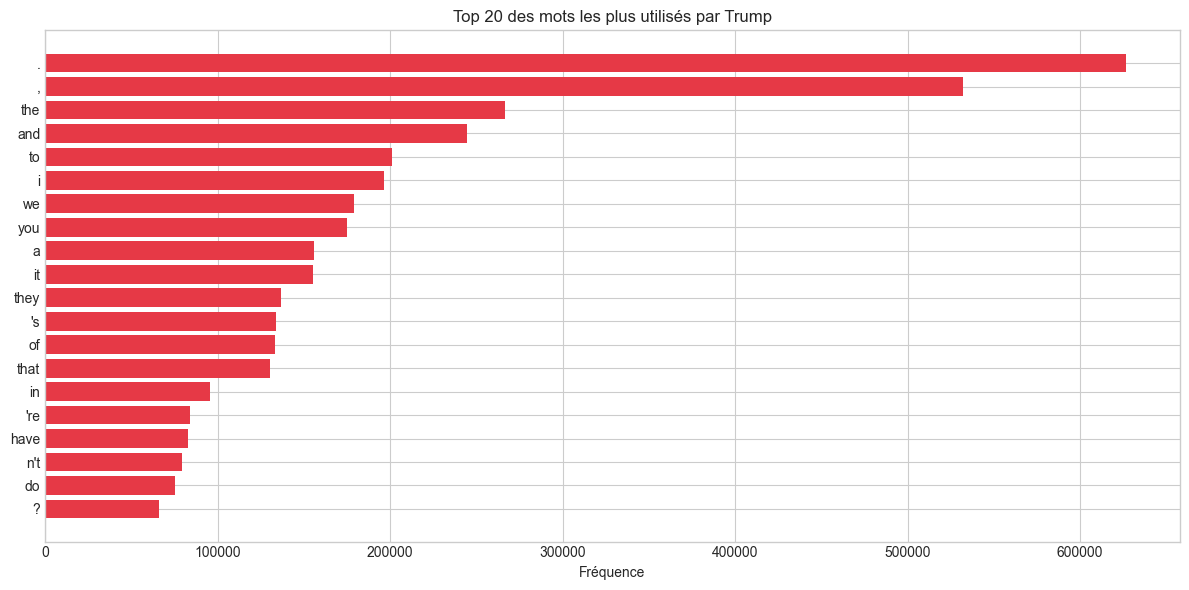

Top 10 :
   .: 626,635
   ,: 532,376
   the: 266,819
   and: 244,596
   to: 200,851
   i: 196,727
   we: 179,096
   you: 174,975
   a: 155,650
   it: 155,571


In [ ]:
#On tokenize nos mots, ça prend un peu de temps (~30 sec)
all_words = []
for text in transcriptions_df['text'].dropna():
    all_words.extend(text.lower().split())
print(all_words[:10])
all_text=' '.join(all_words)
print(all_text[:100])
from nltk.tokenize import word_tokenize
all_words=word_tokenize(all_text)
print(all_words[:10])
word_counts_raw = Counter(all_words)
top_20_raw = word_counts_raw.most_common(20)

fig, ax = plt.subplots(figsize=(12, 6))
words, counts = zip(*top_20_raw)
ax.barh(words, counts, color='#E63946')
ax.invert_yaxis()
ax.set_xlabel('Fréquence')
ax.set_title('Top 20 des mots les plus utilisés par Trump')
plt.tight_layout()
plt.show()
print("Top 10 :")
for w, c in top_20_raw[:10]:
    print(f"   {w}: {c:,}")

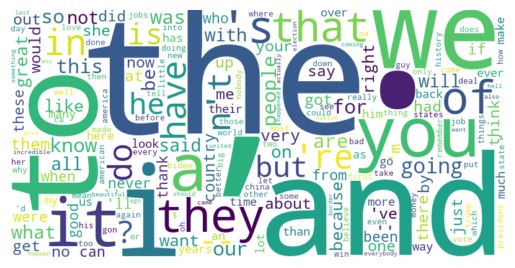

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wc = WordCloud(width=800, height=400, background_color="white")
wc = wc.generate_from_frequencies(word_counts_raw)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

**Observation** : Les mots les plus fréquents sont tous des **stop words** (mots vides en anglais) comme "the", "and", "to", "a", "of"...

Ces mots n'apportent aucune information sur le contenu ou le style de Trump. On doit les filtrer pour voir les mots réellement intéressants.

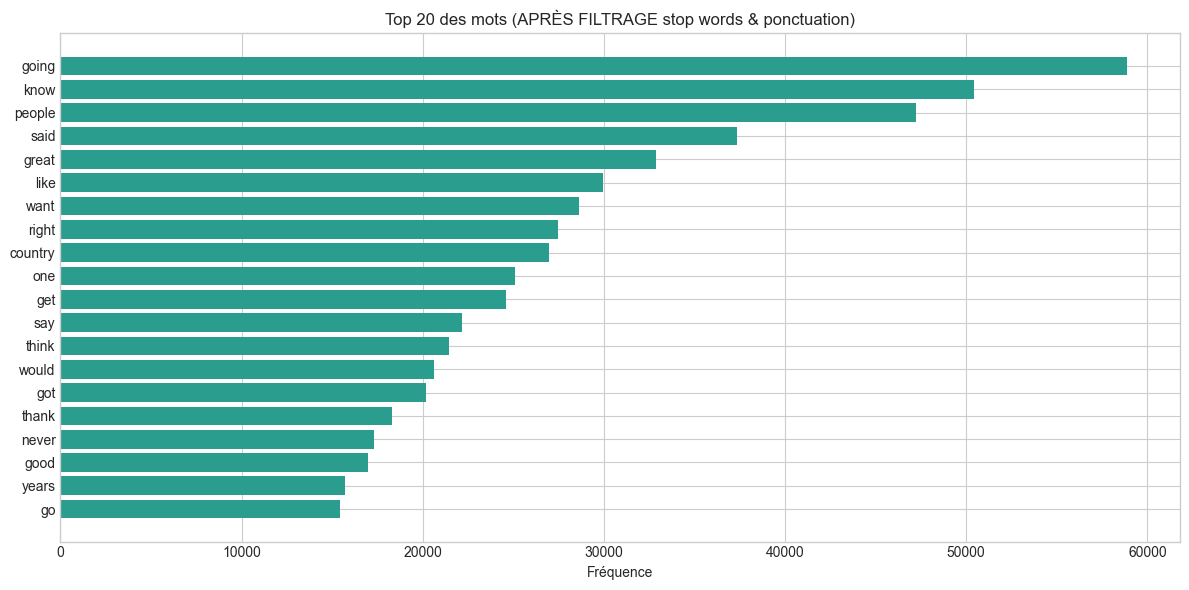

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
stop_words = set(stopwords.words("english"))
punctuation = set(string.punctuation) 
punctuation.update(['``', "''", '--', '...', '“', '”', '’', '—', '–'])
nltk_artifacts = {"'s", "n't", "'re", "'ve", "'m", "'ll", "'d"}
# Filtrage des stop words ET de la ponctuation ET des petits tokens non intéressants
all_words_filtered = [(w, c) for w, c in word_counts_raw.most_common(200) if w.lower() not in stop_words and w not in punctuation and w not in nltk_artifacts]
top_words_filtered = all_words_filtered[:20]
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
words, counts = zip(*top_words_filtered)
ax.barh(words, counts, color='#2A9D8F')
ax.invert_yaxis()
ax.set_xlabel('Fréquence')
ax.set_title('Top 20 des mots (APRÈS FILTRAGE stop words & ponctuation)')
plt.tight_layout()
plt.show()



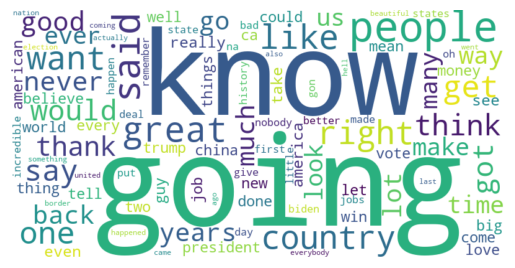

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_words_filtered_counter=Counter(dict(all_words_filtered))
wc = WordCloud(width=800, height=400, background_color="white")
wc = wc.generate_from_frequencies(all_words_filtered_counter)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

C'est mieux ! Maintenant on voit des mots qui caractérisent vraiment les discours de Trump : **"people"**, **"country"**, **"great"**, **"president"**, **"America"**, etc.

### 3.7 Longueur moyenne des phrases

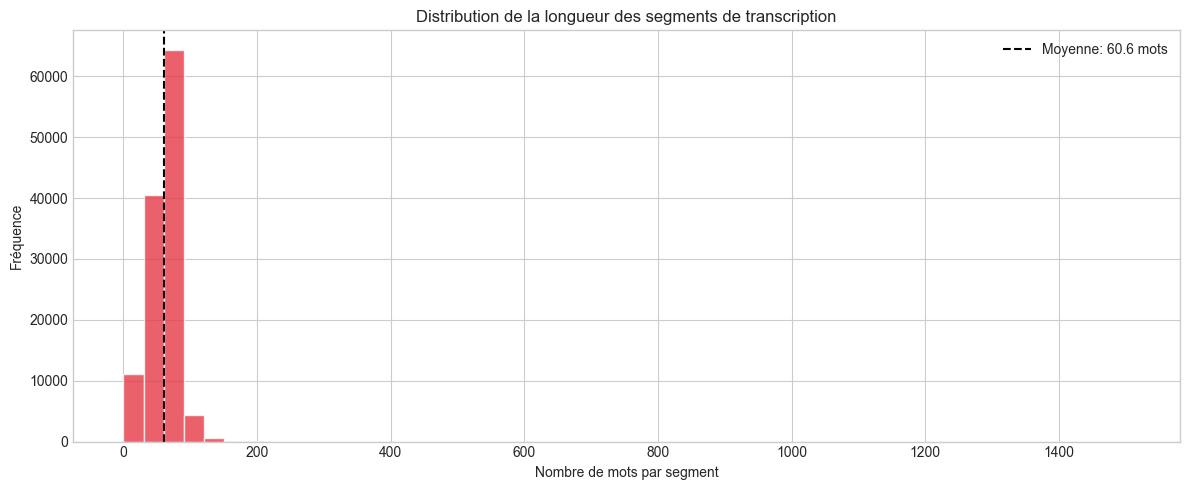

In [ ]:
# Calcul de la longueur moyenne des phrases
transcriptions_df['word_count'] = transcriptions_df['text'].str.split().str.len()

fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(transcriptions_df['word_count'].dropna(), bins=50, color='#E63946', edgecolor='white', alpha=0.8)
ax.axvline(transcriptions_df['word_count'].mean(), color='black', linestyle='--', 
           label=f"Moyenne: {transcriptions_df['word_count'].mean():.1f} mots")
ax.set_xlabel('Nombre de mots par segment')
ax.set_ylabel('Fréquence')
ax.set_title('Distribution de la longueur des segments de transcription')
ax.legend()
plt.tight_layout()
plt.show()

---

## Partie 4 : Comparaison Trump vs Biden vs Kamala

On a également scrapé les discours de Biden et Kamala Harris pour comparer les styles.

In [ ]:
# Chargement des données Biden/Harris
other_transcriptions = pd.read_parquet('../data/other_transcriptions.parquet')
other_transcriptions['text'] = other_transcriptions['text'].str.replace(r"\[.*?\]", "", regex=True, flags=re.DOTALL).str.strip()
# on sépare Biden et kamala
biden_transcriptions = other_transcriptions[other_transcriptions['person_name'] == 'Joe Biden'].copy()
harris_transcriptions = other_transcriptions[other_transcriptions['person_name'] == 'Kamala Harris'].copy()
print(f"Taille du corpus :")
print(f"   Trump  : {len(transcriptions_df):,} segments")
print(f"   Biden  : {len(biden_transcriptions):,} segments")
print(f"   Harris : {len(harris_transcriptions):,} segments")

Taille du corpus :
   Trump  : 121,034 segments
   Biden  : 5,428 segments
   Harris : 1,206 segments


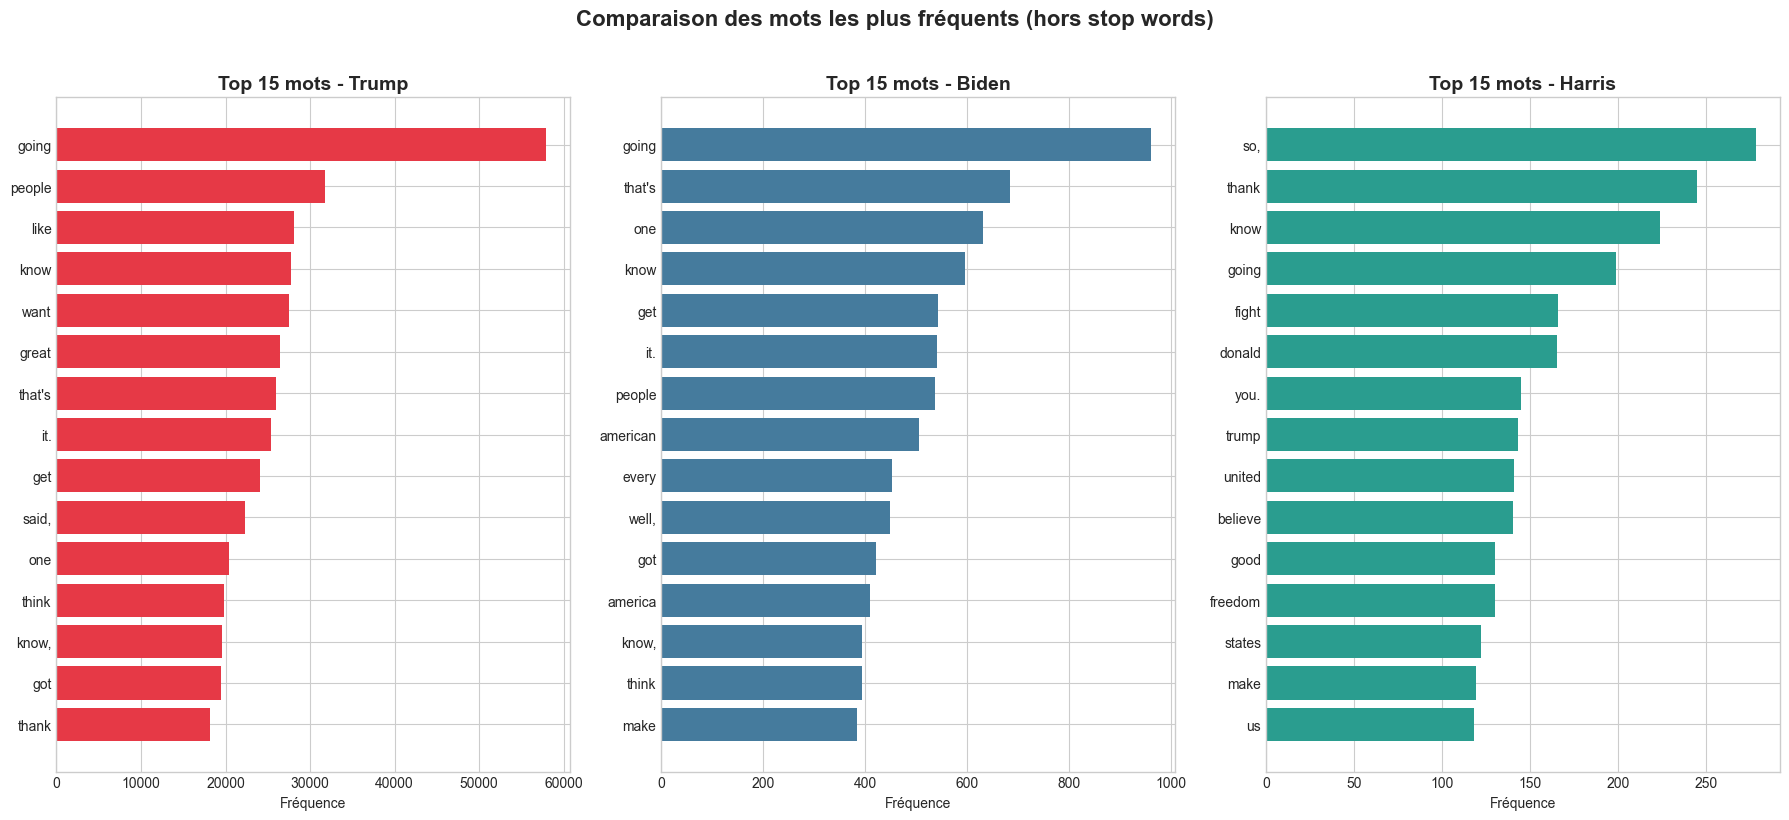

In [ ]:
def get_top_words(df, n=15):
    words = []
    for text in df['text'].dropna():
        words.extend(text.lower().split())
    counts = Counter(words)
    return [(w, c) for w, c in counts.most_common(300) if w not in stop_words and w not in punctuation and w not in nltk_artifacts][:n]
trump_top = get_top_words(transcriptions_df)
biden_top = get_top_words(biden_transcriptions)
harris_top = get_top_words(harris_transcriptions)
# Affichage côte à côte
fig, axes = plt.subplots(1, 3, figsize=(18, 8))
for ax, (data, name, color) in zip(axes, [(trump_top, 'Trump', '#E63946'),(biden_top, 'Biden', '#457B9D'),(harris_top, 'Harris', '#2A9D8F')]):
    words, counts = zip(*data)
    ax.barh(words, counts, color=color)
    ax.invert_yaxis()
    ax.set_title(f'Top 15 mots - {name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Fréquence')

plt.suptitle('Comparaison des mots les plus fréquents (hors stop words)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### 4.1 Mots caractéristiques de chaque candidat

In [ ]:
# Mots spécifiques à chaque candidat
trump_words = set(w for w, _ in trump_top)
biden_words = set(w for w, _ in biden_top)
harris_words = set(w for w, _ in harris_top)
only_trump = trump_words - biden_words - harris_words
only_biden = biden_words - trump_words - harris_words
only_harris = harris_words - trump_words - biden_words
print("Mots UNIQUES à Trump (dans le top 15) :")
print(f"   {only_trump}")
print()
print("Mots UNIQUES à Biden :")
print(f"   {only_biden}")
print()
print("Mots UNIQUES à Harris :")
print(f"   {only_harris}")

Mots UNIQUES à Trump (dans le top 15) :
   {'like', 'said,', 'want', 'great'}

Mots UNIQUES à Biden :
   {'every', 'american', 'well,', 'america'}

Mots UNIQUES à Harris :
   {'states', 'so,', 'freedom', 'you.', 'good', 'fight', 'united', 'trump', 'us', 'believe', 'donald'}


### 4.2 Comparaison de la longueur des interventions

C:\Users\nicol\AppData\Local\Temp\ipykernel_30296\1055755398.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=['Trump', 'Biden', 'Harris'], patch_artist=True)


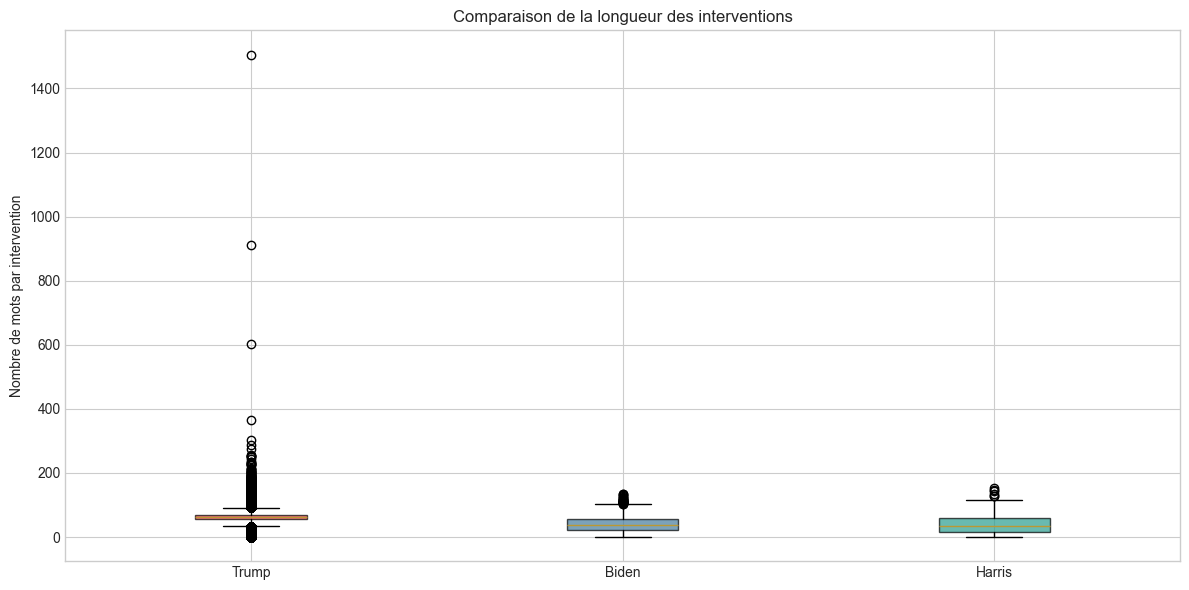

Moyenne de mots par segment :
   Trump  : 60.6
   Biden  : 39.3
   Harris : 38.8


In [ ]:
# Calcul de la longueur des segments
biden_transcriptions['word_count'] = biden_transcriptions['text'].str.split().str.len()
harris_transcriptions['word_count'] = harris_transcriptions['text'].str.split().str.len()

fig, ax = plt.subplots(figsize=(12, 6))

data = [transcriptions_df['word_count'].dropna(),biden_transcriptions['word_count'].dropna(),harris_transcriptions['word_count'].dropna()]

bp = ax.boxplot(data, labels=['Trump', 'Biden', 'Harris'], patch_artist=True)

colors = ['#E63946', '#457B9D', '#2A9D8F']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax.set_ylabel('Nombre de mots par intervention')
ax.set_title('Comparaison de la longueur des interventions')
plt.tight_layout()
plt.show()

print(f"Moyenne de mots par segment :")
print(f"   Trump  : {transcriptions_df['word_count'].mean():.1f}")
print(f"   Biden  : {biden_transcriptions['word_count'].mean():.1f}")
print(f"   Harris : {harris_transcriptions['word_count'].mean():.1f}")

### 4.3 En donnant une phrase, peut-on prédire qui des trois l'a dit ?

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
# On crée des dataframes simplifiés avec juste le texte et le label
df_trump = transcriptions_df[['text']].copy()
df_trump['speaker'] = 'Trump'
df_biden = biden_transcriptions[['text']].copy()
df_biden['speaker'] = 'Biden'
df_harris = harris_transcriptions[['text']].copy()
df_harris['speaker'] = 'Harris'
# Équilibrage des classes (pour éviter le biais d'avoir trump tout le temps)
# On prend autant de Trump que de Biden (~5000) pour avoir un comparatif juste
n_samples = len(df_biden)
df_trump_sample = df_trump.sample(n=n_samples)
# On concatène tout (Harris est un peu moins présente, c'est ok)
df_all = pd.concat([df_trump_sample, df_biden, df_harris])
# Nettoyage rapide des NaNs éventuels
df_all = df_all.dropna(subset=['text'])
print(f"Jeu de données assemblé : {len(df_all)} exemples")
print(df_all['speaker'].value_counts())

#Vectorisation
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df_all['text'])
y = df_all['speaker']

#on fait un knn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
knn = KNeighborsClassifier(n_neighbors=7, metric='cosine') #on prend cosine car c'est a priori le mieux en nlp
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(f"\nExactitude (Accuracy) : {accuracy_score(y_test, y_pred):.2%}")
print("\nDétails par candidat :")
print(classification_report(y_test, y_pred))

def predict_speaker(text):
    vec = vectorizer.transform([text])
    pred = knn.predict(vec)[0]
    # On peut aussi récupérer les probas si on veut
    return pred

# Quelques exemples
samples = [
    "Make America Great Again",
    "We have to build back better for the working class", 
    "We will fight for freedom and democracy"
]

print("-" * 30)
for s in samples:
    print(f"Phrase : '{s}' -> Prédit : {predict_speaker(s)}")

Jeu de données assemblé : 12062 exemples
speaker
Trump     5428
Biden     5428
Harris    1206
Name: count, dtype: int64

Exactitude (Accuracy) : 76.63%

Détails par candidat :
              precision    recall  f1-score   support

       Biden       0.75      0.84      0.80      1060
      Harris       0.56      0.73      0.63       234
       Trump       0.85      0.70      0.77      1119

    accuracy                           0.77      2413
   macro avg       0.72      0.76      0.73      2413
weighted avg       0.78      0.77      0.77      2413

------------------------------
Phrase : 'Make America Great Again' -> Prédit : Trump
Phrase : 'We have to build back better for the working class' -> Prédit : Biden
Phrase : 'We will fight for freedom and democracy' -> Prédit : Harris


In [ ]:
France_lover=predict_speaker('I love France')
print(f"C'est {France_lover} qui nous aime le plus !")

C'est Harris qui nous aime le plus !


---

## Partie 5 : Modélisation par N-grammes

On utilise un modèle de trigrammes pour prédire le mot suivant dans une phrase.

### Principe

Un trigramme est une séquence de 3 mots consécutifs. On compte combien de fois chaque trigramme apparaît dans le corpus, puis on prédit le 3ème mot connaissant les 2 premiers.

In [ ]:
from nltk.util import ngrams
# Construction du modèle de trigrammes
ngram_counts = defaultdict(Counter)
for text in transcriptions_df['text'].dropna():
    tokens = text.lower().split()
    for w1, w2, w3 in ngrams(tokens, 3):
        ngram_counts[(w1, w2)][w3] += 1

print(f"Nombre de contextes uniques (paires de mots) : {len(ngram_counts):,}")

Nombre de contextes uniques (paires de mots) : 1,033,351


In [ ]:
def predict(starting_phrase, n_words=10):
    words = starting_phrase.lower().split()
    
    for _ in range(n_words):
        context = tuple(words[-2:])
        if context not in ngram_counts or not ngram_counts[context]:
            break
        next_word = ngram_counts[context].most_common(1)[0][0]
        words.append(next_word)
    
    return " ".join(words)

test_phrases = ['Make America Great', 'The fake news', 'We are going', 'China is']
for phrase in test_phrases:
    print(f"   '{phrase}' → {predict(phrase)}")

   'Make America Great' → make america great again. thank you, everybody. thank you. thank you. thank you.
   'The fake news' → the fake news media is so important. and i said, "you know, i
   'We are going' → we are going to be a great job. and i said, "you know,
   'China is' → china is building a massive tax cuts and reforms in american history.


On se rend compte que notre modèle prend peu de "risque" dans le sens où il prédit systématiquement la même chose, ce qui ne laisse pas la possibilité a de nouvelles phrases plus créatives

### 5.1 Ajout d'aléatoire pondéré

Le modèle greedy donne toujours la même réponse. On peut ajouter du hasard pondéré par les probabilités.

In [ ]:
import random

def predict_random(starting_phrase, n_words=15):
    words = starting_phrase.lower().split()
    for _ in range(n_words):
        context = tuple(words[-2:])
        if context not in ngram_counts or not ngram_counts[context]:
            break
        candidates = ngram_counts[context].most_common()
        total = sum(c for _, c in candidates)
        r = random.random() * total
        cumul = 0
        for word, freq in candidates:
            cumul += freq
            if r <= cumul:
                words.append(word)
                break
    return " ".join(words)

# Génération de variations
print("5 variations aléatoires de 'Make America Great' :")
for i in range(5):
    print(f"   {i+1}. {predict_random('Make America Great')}")

5 variations aléatoires de 'Make America Great' :
   1. make america great again, right? nope. no threat as dangerous as can be. so, i said let's wait.
   2. make america great again, and launched by private american companies, if they can't believe it or not. cut
   3. make america great again. i said, "i can be summed up as many justices as possible to fly
   4. make america great again. right? that's what they want, but she should resign. under both candidates. people like
   5. make america great again. and then they decide to beat them all. so with that, how dare --


### 5.2 D'autres exemples

In [ ]:
prompts = [
    "I will",
    "The media",
    "Our country",
    "Sleepy Joe",
    "We love"
]

for prompt in prompts:
    print(f"   • \"{predict_random(prompt, 12)}\"")
    print()

   • "i will fix it. but she gets four more years of kamala harris, and"

   • "the media will know once we do these lockdowns like your support. you have"

   • "our country was going to be a safe zone overseas and to bring back"

   • "sleepy joe or crooked joe? ok, ready? we are americans. and to stop it"

   • "we love you. thank you, fellows. thanks. i remember i used to be president"



: 

## Modularité et App Streamlit

Nous avons mis en place un pipeline de nettoyage de transcriptions pour l’analyse de texte.
Il comprend la tokenization, la suppression de la ponctuation et des stopwords, ainsi qu’une étape de lemmatization afin de ramener les mots à leur forme canonique.
Le pipeline est modulaire et permet de comparer différentes stratégies de pré-traitement sur un même corpus.

#### Technologies utilisées
- spaCy
Utilisé pour la tokenization, la gestion de la ponctuation et la liste des stopwords.
Les composants lourds (parser, NER, tagger) sont désactivés pour des raisons de performance.

- simplemma
Utilisé pour la lemmatization, afin de ramener chaque mot à sa forme canonique.

- pandas
Utilisé pour appliquer le pipeline directement sur des fichiers Parquet.


Nous commençons par une normalisation simple :
- passage en minuscules
- suppression de la ponctuation
- suppression des annotations entre crochets (ex. [APPLAUSE])

sans suppression des stopwords
sans lemmatization

In [11]:
def basic_normalization(text: str) -> str:
    doc = nlp(text.lower(), disable=['parser', 'ner', 'tagger'])
    tokens = [t.text for t in doc if not t.is_punct]
    return " ".join(tokens)


Nous filtrons ensuite les tokens pour :
 - supprimer les stopwords
 - supprimer les tokens non alphabétiques
 - conserver uniquement les mots porteurs de sens

In [12]:
def token_cleaning(text: str) -> str:
    doc = nlp(text, disable=['parser', 'ner', 'tagger'])
    stopwords = nlp.Defaults.stop_words
    tokens = [
        t.text for t in doc
        if t.is_alpha and t.text.lower() not in stopwords
    ]
    return " ".join(tokens)

---> voir scripts/cleaning/run_pipeline.py

---> voir le fichier parquet avec les différentes colonnes : tad data/transcriptions.parquet

---> lancer l'app : streamlit run app.py

---

## Conclusion

Ce projet a permis de :

1. **Collecter** plus de 800 discours de Trump (et 60+ de Biden/Harris) via webscraping
2. **Analyser** le vocabulaire caractéristique de chaque candidat
3. **Visualiser** l'évolution temporelle, les catégories et les mots-clés
4. **Modéliser** le style de Trump avec un modèle N-gramme capable de compléter ses phrases

### Limites et pistes d'amélioration

- Le modèle N-gramme est simple mais produit parfois des boucles
- Un modèle plus avancé (LSTM, GPT-2) donnerait de meilleurs résultats
- L'analyse temporelle des discours pourrait être approfondie (évolution du vocabulaire selon les périodes)

---

## Annexe : Reproductibilité

Pour re-exécuter le scraping complet :

```bash
# 1. Installer les dépendances
pip install -r requirements.txt

# 2. Scraper les URLs (Trump)
python scripts/speech_url_scrap.py --candidate trump

# 3. Extraire les transcriptions
python scripts/process_speeches.py --candidate trump

# 4. Nettoyer les transcriptions
python scripts/clean_transcriptions.py --candidate trump

# Répéter pour Biden et Harris
python scripts/speech_url_scrap.py --candidate biden
python scripts/process_speeches.py --candidate biden
python scripts/clean_transcriptions.py --candidate biden
```